### 1. Package setup

In [178]:
import scipy
import math
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt
from curvefit.core.model import CurveModel
from curvefit import pv
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from curvefit.core.functions import log_erf, erf, expit, log_expit

### 2. Input data setup

In [2]:
# Model active cases
# Need to transform this data format to an amenable format for the IHME model
active_cases_india = 'time_series_covid19_confirmed_India_20200410.csv'
# Active cases Bengaluru: as of 10 April from https://github.com/dishamakhija/covid19-india/
active_cases_bengaluru = 'time_series_bengaluru.csv'

In [3]:
def generalized_logistic(t, params) :
    alpha = params[0]
    beta  = params[1]
    p     = params[2]
    return p / ( 1.0 + np.exp( - alpha * ( t - beta ) ) )

### 3. Load input data

In [4]:
df_india = pd.read_csv(active_cases_india)
df_bengaluru = pd.read_csv(active_cases_bengaluru)
karnataka_cases = df_india.loc[df_india['Province/State'] == 'Karnataka']
bengaluru_cases = df_bengaluru.loc[df_bengaluru['Province/State'] == 'Bengaluru']

In [5]:
train_date_start = datetime.datetime(2020, 3, 23)
train_date_end = datetime.datetime(2020, 4, 1)
test_date_start = datetime.datetime(2020, 4, 2)
test_date_end = datetime.datetime(2020, 4, 9)

In [92]:
bengaluru_cases

,Province/State,Country/Region,Lat,Long,10/03/20,11/03/20,12/03/20,13/03/20,14/03/20,15/03/20,...,01/04/20,02/04/20,03/04/20,04/04/20,05/04/20,06/04/20,07/04/20,08/04/20,09/04/20,10/04/20
0,Bengaluru,India,20,70,3,3,4,4,4,4,...,46,46,46,50,52,54,57,58,63,63


In [7]:
karnataka_cases

,Province/State,Country/Region,Lat,Long,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,...,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10
14,Karnataka,India,20,70,1.0,4.0,4.0,6.0,6.0,6.0,...,101.0,110.0,124.0,128.0,144.0,151.0,175.0,175.0,181.0,181.0


### 4. Prepare data in the IHME format

In [93]:
def fetch_columns(df, start_date, end_date, under_reporting_factor):
    """
    Helper function to fetch the columns from the active cases df
    Assumption: df contains only 1 row corresponding to the Province/Region 
    of interest
    """
    # The code for fetching the dates from the df is not clean
    # will clean it up later
    active_cases = []
    date = start_date
    delta = datetime.timedelta(days=1)
    count_df = pd.DataFrame(columns=["date", "active_count"])
    while date <= end_date:
        ##### NOTE - CHANGED DATE FORMAT FOR BLORE DATA
        num_active = df[date.strftime('%d/%m/%y')].values[0]
        count_df = count_df.append({
         "date": date,
         "active_count": num_active 
          }, ignore_index=True)
        date += delta
    
    count_df = count_df.sort_values(by='date', ascending=True)
    count_df.active_count = count_df.active_count*under_reporting_factor
    count_df['cumulative_count'] = count_df.active_count.cumsum()
    count_df['cumulative_count'] = count_df['cumulative_count']
    print(count_df)
    return count_df

def create_ihme_input(region, active_case_df, train_date_start, train_date_end, 
                      test_date_start, test_date_end,under_reporting_factor, col_covariate_vars,
                      social_distance):
    """
    active_case_df : Active caess for the Province/State under consideration (pd.Dataframe)
    train_date_start, train_date_end : Date range for train time frame
    test_date_start, test_date_end : Date range for test time frame
    """
    train_active_cases_df = fetch_columns(active_case_df, train_date_start, train_date_end, under_reporting_factor)
    test_active_cases_df = fetch_columns(active_case_df, test_date_start, test_date_end, under_reporting_factor)
    
    num_points = (train_active_cases_df.shape[0])
    
    assert(len(social_distance) == num_points)
    # As of now we assume all variates have same variance
    assert(len(col_covariate_vars) == num_points)
    
    num_train_days = (train_date_end - train_date_start).days + 1
    print(num_train_days)
    independent_var   = train_active_cases_df.index
    measurement_value = train_active_cases_df['cumulative_count']
    covariate_var     = col_covariate_vars
    print(covariate_var)
    social_distance   = [1 for i in range(num_train_days)]
    data_group        = num_train_days * [region]
    data_dict         = {
        'independent_var'   : independent_var   ,
        'measurement_value' : measurement_value ,
        'covariate_var'     : covariate_var     ,
        'social_distance'   : social_distance   ,
        'region'        : region        ,
    }
    train_df = pd.DataFrame(data_dict)
    print(train_df)
    return train_df, train_active_cases_df, test_active_cases_df

# Functions
# identity function
def identity_fun(x):
    return x
# link function used for alpha, p
def exp_fun(x):
    return np.exp(x)

def compute_mape(y_true, y_pred):
    mape = 0
    for i in range(len(y_pred)):
        if(not y_true[i] == 0):
            mape+= np.abs((y_true[i] - y_pred[i] + 0.) / y_true[i])
    mape = (100*mape)/len(y_pred)
    return mape

def rmse_error(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred)
            
    rmse = math.sqrt(rmse)
    return rmse

def rmsle_error(y_true, y_pred):
    rmsle = mean_squared_log_error(y_true, y_pred)
            
    rmsle = math.sqrt(rmsle)
    return rmsle



### 4. Model
### Model assumptions
- Independent variable - Day
- Measurement val - number of active cases
- Social distancing - 1.0  # TODO: Need to understand scale

In [113]:
region = 'Bengaluru'
num_train_days = (train_date_end - train_date_start).days + 1 # Account for the boundary case
print(num_train_days)
col_covariate_vars = num_train_days * [1.11]
social_distance = num_train_days * [10.0]
under_reporting_factor = 2
train_df, train_active_cases, test_active_cases = create_ihme_input(region, bengaluru_cases,
                                                                   train_date_start, train_date_end,
                                                                   test_date_start, test_date_end, 
                                                                    under_reporting_factor,
                                                                   col_covariate_vars, social_distance)

10
        date active_count cumulative_count
0 2020-03-23           44               44
1 2020-03-24           46               90
2 2020-03-25           62              152
3 2020-03-26           66              218
4 2020-03-27           74              292
5 2020-03-28           78              370
6 2020-03-29           78              448
7 2020-03-30           78              526
8 2020-03-31           86              612
9 2020-04-01           92              704
        date active_count cumulative_count
0 2020-04-02           92               92
1 2020-04-03           92              184
2 2020-04-04          100              284
3 2020-04-05          104              388
4 2020-04-06          108              496
5 2020-04-07          114              610
6 2020-04-08          116              726
7 2020-04-09          126              852
10
[1.11, 1.11, 1.11, 1.11, 1.11, 1.11, 1.11, 1.11, 1.11, 1.11]
   independent_var measurement_value  covariate_var  social_distance  \
0

In [149]:
# curve_model
num_params   = 3 # alpha, beta and p
num_fe       = 3 # fixed effect parameters
col_t        = 'independent_var'
col_obs      = 'measurement_value'
col_covs     = num_params *[['covariate_var']]
col_group    = 'region'
param_names  = ['alpha', 'beta', 'p']
link_fun     = [exp_fun, identity_fun, exp_fun ]
var_link_fun = num_fe * [identity_fun ]
fun          = erf

In [150]:
col_covs

[['covariate_var'], ['covariate_var'], ['covariate_var']]

In [ ]:
# Initialize params
fe_init   = np.ones(num_fe)
re_init   = np.ones(num_fe)
fe_bounds = [[-np.inf, np.inf], [0, np.inf], [0, np.inf]] 
print(fe_bounds)
re_bounds = [[0.0, 0.0]] * num_fe

In [167]:
# var_a = [1e-3,1e-2,1e-1,0,1,10,100,1000]
var_b = [1e-3,1e-2,1e-1,0,1,10,100,1000]
var_c = [1e-3,1e-2,1e-1,0,1,10,100,1000]

train_df['var_a'] = 0
train_df['var_b'] = 0
train_df['var_c'] = 0
all_metrics = []
for i in var_a:
    for j in var_b:
        for k in var_c:
            flat = {}
            train_df['var_a'] = i
            train_df['var_b'] = j
            train_df['var_c'] = k
            col_covs = [['var_a'],['var_b'],['var_c']]
            curve_model = CurveModel(
            train_df,
            col_t,
            col_obs,
            col_covs,
            col_group,
            param_names,
            link_fun,
            var_link_fun,
            fun
            )
            curve_model.fit_params(fe_init, re_init, fe_bounds, re_bounds)
            params_estimate = curve_model.params
            fe_estimate     = curve_model.result.x[: num_fe]
            flat['alpha'] = params_estimate[0][0]
            flat['beta'] = params_estimate[1][0]
            flat['p'] = params_estimate[2][0]
            
            out_train = curve_model.predict(
            t=np.array(np.arange(0, 10)),
            group_name=region
            )
            
            if(( (np.max(out_train))!=np.inf) & ((np.isnan(out_train).any()==False))):
                flat['train_mape'] = compute_mape(train_active_cases['cumulative_count'], out_train)
                flat['train_rmsle'] = rmsle_error(train_active_cases['cumulative_count'], out_train)
            else:
                flat['train_mape'] = np.inf
                flat['train_rmsle'] = np.inf
            
            test_out = curve_model.predict(
            t=np.array(np.arange(10, 18)),
            group_name=region
            )
            
            
            if( ((np.max(test_out))!=np.inf) & ((np.isnan(test_out).any())==False)):
                flat['test_mape'] = compute_mape(test_active_cases['cumulative_count'], test_out)
                flat['test_rmsle'] = rmsle_error(test_active_cases['cumulative_count'], test_out)
            else:
                flat['test_mape'] = np.inf
                flat['test_rmsle'] = np.inf
            
            print(flat)
            all_metrics.append(flat)

{'alpha': 1.001000500348071, 'beta': 0.0009999996258430231, 'p': 1.0010005288363142, 'train_mape': 99.5390007618274, 'train_rmsle': 4.9697838241158925, 'test_mape': 99.6420248578265, 'test_rmsle': 5.269715590922418}
{'alpha': 0.1752948340226588, 'beta': 5.930980080750902, 'p': 891.3623446818791, 'train_mape': 7.210798019228132, 'train_rmsle': 0.11782465551871439, 'test_mape': 188.86884037643986, 'test_rmsle': 1.0476804495291612}
{'alpha': 0.17536413195136077, 'beta': 5.928960068564515, 'p': 891.0246626947086, 'train_mape': 7.20315316035902, 'train_rmsle': 0.11765199897522591, 'test_mape': 188.8078824536268, 'test_rmsle': 1.0475187061876219}
{'alpha': 1.0010005001667084, 'beta': 0.001, 'p': 1.0, 'train_mape': 99.53946154389433, 'train_rmsle': 4.970264653806269, 'test_mape': 99.64238266428325, 'test_rmsle': 5.270211263977598}
{'alpha': 0.17534436644616128, 'beta': 5.929816137443398, 'p': 891.1586706218874, 'train_mape': 7.204623809853219, 'train_rmsle': 0.11767340068210236, 'test_mape': 

/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)


{'alpha': 0.17534407013832962, 'beta': 5.929827928846345, 'p': 891.1602386584441, 'train_mape': 7.204646069671272, 'train_rmsle': 0.1176737285086457, 'test_mape': 188.83430865028313, 'test_rmsle': 1.047589197805665}
{'alpha': 0.9852814336724797, 'beta': 3.6425995981949013, 'p': 530.4952567690132, 'train_mape': 47.28318079638829, 'train_rmsle': 2.1179741107128325, 'test_mape': 109.13877307576436, 'test_rmsle': 0.7892845041243464}
{'alpha': 0.9432229351640669, 'beta': 13.647046552393649, 'p': 2.6881171418161356e+43, 'train_mape': 1.0864622860490803e+32, 'train_rmsle': 30.35728415456057, 'test_mape': 2.0344909159898533e+42, 'test_rmsle': 90.53488179201754}
{'alpha': 1.0010005001667084, 'beta': 0.01, 'p': inf, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': inf, 'test_rmsle': inf}
{'alpha': 1.0010005003521798, 'beta': 0.09999589178438674, 'p': 1.00100052879783, 'train_mape': 99.55428103590694, 'train_rmsle': 4.973368525411948, 'test_mape': 99.64202485784025, 'test_rmsle': 5.26971559094

/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)


{'alpha': 0.1753438179596104, 'beta': 5.929839072428224, 'p': 891.1618765514482, 'train_mape': 7.204663453455829, 'train_rmsle': 0.11767394701665108, 'test_mape': 188.83461638170004, 'test_rmsle': 1.0475900173079031}
{'alpha': 1.0008505193510226, 'beta': 3.634206455010633, 'p': 529.5761578489032, 'train_mape': 47.44084763789875, 'train_rmsle': 2.1286102259721567, 'test_mape': 108.90637363409981, 'test_rmsle': 0.7884979182279486}
{'alpha': 0.9972375810977406, 'beta': 88.96421322489373, 'p': 3.316712526473749e+43, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': 1.0010005001667084, 'beta': 0.1, 'p': inf, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': inf, 'test_rmsle': inf}
{'alpha': 1.001000500348028, 'beta': 0.0, 'p': 1.0010005288366846, 'train_mape': 99.53884851544072, 'train_rmsle': 4.969749195164845, 'test_mape': 99.64202485782636, 'test_rmsle': 5.2697155909222335}
{'alpha': 0.1400083847370668, 'beta': 0.0, 'p

/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)


{'alpha': 1.0006518829808946, 'beta': 0.0, 'p': 376.7729128215197, 'train_mape': 99.4097159904658, 'train_rmsle': 0.7619168655822641, 'test_mape': 77.00201994856175, 'test_rmsle': 0.7029432930273868}
{'alpha': 1.638218753816847e+89, 'beta': 0.0, 'p': 371.24324375189775, 'train_mape': 100.95285316162419, 'train_rmsle': 0.7713376105107702, 'test_mape': 76.23881762832585, 'test_rmsle': 0.7027204641727551}
{'alpha': 1.0010005001667084, 'beta': 0.0, 'p': inf, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': inf, 'test_rmsle': inf}
{'alpha': 0.17534387844175497, 'beta': 5.929834553910269, 'p': 891.16094559572, 'train_mape': 7.204661618555022, 'train_rmsle': 0.11767398481094875, 'test_mape': 188.83439089840272, 'test_rmsle': 1.0475894098436964}
{'alpha': 0.17534046261154618, 'beta': 5.929906492783721, 'p': 891.1734518675681, 'train_mape': 7.205104964466396, 'train_rmsle': 0.11768510199335255, 'test_mape': 188.8363949822799, 'test_rmsle': 1.0475946817352995}
{'alpha': 0.17534927524745111, '

/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)


{'alpha': 0.1753448056428533, 'beta': 5.9298056296313915, 'p': 891.1565350283768, 'train_mape': 7.204567099140936, 'train_rmsle': 0.11767198110133291, 'test_mape': 188.83363337523718, 'test_rmsle': 1.0475874048256573}
{'alpha': 1.0009778294571372, 'beta': 58.79668942556389, 'p': 20456.077905741953, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': 1.0009922815777748, 'beta': 21.99999839498084, 'p': 2.6881171418161356e+43, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 2.8821707484782875e+29, 'test_rmsle': 23.72598463989526}
{'alpha': 1.0010005001667084, 'beta': 1.0, 'p': inf, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': inf, 'test_rmsle': inf}
{'alpha': 1.0179277357265122, 'beta': 3.6404407103568595, 'p': 530.0097280873289, 'train_mape': 47.68498376376122, 'train_rmsle': 2.1487168718708833, 'test_mape': 109.01600435950685, 'test_rmsle': 0.7888687717640704}
{'alpha': 0.1753451505880087, 'beta

/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp



{'alpha': 1.0010004073362266, 'beta': 0.0, 'p': 1.0, 'train_mape': 99.5393094518882, 'train_rmsle': 4.970230047208288, 'test_mape': 99.64238266428325, 'test_rmsle': 5.270211263977598}
{'alpha': 0.17534415498827752, 'beta': 5.929825123173123, 'p': 891.1597340485748, 'train_mape': 7.204637178472917, 'train_rmsle': 0.11767353529984206, 'test_mape': 188.83420855149464, 'test_rmsle': 1.0475889308027913}
{'alpha': 1.0010005974411753, 'beta': 19.999965471984687, 'p': 21455.568247575266, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 99.9965848515026, 'test_rmsle': 5.928641475934642}
{'alpha': 1.0010006004129637, 'beta': 19.99999994985384, 'p': 2.6881171418161356e+43, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 4.27782627826524e+36, 'test_rmsle': 45.738969091248514}
{'alpha': 1.0010005001667084, 'beta': 10.0, 'p': inf, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': inf, 'test_rmsle': inf}
{'alpha': 1.0010005001667084, 'beta': 100.0, 'p': 1.001

/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


{'alpha': 1.0010005001667084, 'beta': 1000.0, 'p': 1.1051709180756477, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': 1.0010005001667084, 'beta': 1000.0, 'p': 1.0, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': 1.0010005001667084, 'beta': 1000.0, 'p': 2.718281828459045, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': 1.0010005001667084, 'beta': 1000.0, 'p': 22026.465794806718, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': 1.0010005001667084, 'beta': 1000.0, 'p': 2.6881171418161356e+43, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': 1.0010005001667084, 'beta': 1000.0, 'p': inf, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': inf, 'tes

/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)


{'alpha': 6.961534875899037, 'beta': 9.840590811941903, 'p': 7.766025002742474e+21, 'train_mape': 6203.5935851273725, 'train_rmsle': 5.615910261738679, 'test_mape': 2.7157727007444183e+21, 'test_rmsle': 44.485561687497956}
{'alpha': 1.010050167084168, 'beta': 0.001, 'p': inf, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': inf, 'test_rmsle': inf}
{'alpha': 1.0100501851105212, 'beta': 0.009999962292072931, 'p': 1.0010005288345711, 'train_mape': 99.5401637667372, 'train_rmsle': 4.9700151940406245, 'test_mape': 99.64202485782712, 'test_rmsle': 5.269715590923281}
{'alpha': 0.175382760235468, 'beta': 5.929283831885629, 'p': 891.0789238235288, 'train_mape': 7.199133681387416, 'train_rmsle': 0.11752868118438599, 'test_mape': 188.82782476039958, 'test_rmsle': 1.0475733672313683}
{'alpha': 0.17534537482524393, 'beta': 5.92977781601931, 'p': 891.1514007602761, 'train_mape': 7.2045258828286, 'train_rmsle': 0.11767140521999093, 'test_mape': 188.83250568305874, 'test_rmsle': 1.0475843800454243}

/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)


{'alpha': 0.1753455232502823, 'beta': 5.929771449725657, 'p': 891.1518825443285, 'train_mape': 7.204526642981224, 'train_rmsle': 0.11767171434785792, 'test_mape': 188.83279078563461, 'test_rmsle': 1.0475851643916443}
{'alpha': 0.7178663734798089, 'beta': 81.71005734672777, 'p': 3.307638596958206e+43, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': 1.010050167084168, 'beta': 0.1, 'p': inf, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': inf, 'test_rmsle': inf}
{'alpha': 1.0100501850690098, 'beta': 0.0, 'p': 1.0010005288382866, 'train_mape': 99.5386300439511, 'train_rmsle': 4.969666265761508, 'test_mape': 99.6420248578258, 'test_rmsle': 5.269715590921441}
{'alpha': 0.13999838942019252, 'beta': 0.0, 'p': 477.275554987007, 'train_mape': 93.34906444068407, 'train_rmsle': 0.717028893651912, 'test_mape': 94.39743220597109, 'test_rmsle': 0.737468532015004}
{'alpha': 0.140007967562864, 'beta': 0.0, 'p': 477.26420738323134

/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)


{'alpha': 0.0007079330344005028, 'beta': 0.0, 'p': 689.6951276311421, 'train_mape': 132.86032218928162, 'train_rmsle': 0.8894476538748038, 'test_mape': 72.87950030172846, 'test_rmsle': 0.7034983673573838}
{'alpha': 1.010050167084168, 'beta': 0.0, 'p': inf, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': inf, 'test_rmsle': inf}
{'alpha': 42.49211717378381, 'beta': 1.4067208992298197, 'p': 415.5955529692014, 'train_mape': 61.99900002329135, 'train_rmsle': 1.920404221183941, 'test_mape': 84.13836643429552, 'test_rmsle': 0.7121930251212523}
{'alpha': 0.175341238046614, 'beta': 5.929907263451051, 'p': 891.1735719957902, 'train_mape': 7.204966305215078, 'train_rmsle': 0.11768109038855623, 'test_mape': 188.83668850449882, 'test_rmsle': 1.0475955074080052}
{'alpha': 0.17534162964451158, 'beta': 5.92991530237761, 'p': 891.1732773617214, 'train_mape': 7.204865705413286, 'train_rmsle': 0.11767785885721715, 'test_mape': 188.83662735615198, 'test_rmsle': 1.047595350423582}
{'alpha': 1.010097626

/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)


{'alpha': 1.0077900924683811, 'beta': 58.79398456028167, 'p': 20456.231745484372, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': 1.0092302669807462, 'beta': 21.99984298505902, 'p': 2.6881171418161356e+43, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 1.8932785896574424e+29, 'test_rmsle': 23.581420905202663}
{'alpha': 1.010050167084168, 'beta': 1.0, 'p': inf, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': inf, 'test_rmsle': inf}
{'alpha': 40.85344853401283, 'beta': 1.0135569542592087, 'p': 415.2493357438281, 'train_mape': 51.964013281805194, 'train_rmsle': 1.285698076379764, 'test_mape': 84.06827388502208, 'test_rmsle': 0.7120582946632933}
{'alpha': 0.17534983573765367, 'beta': 5.929630669810689, 'p': 891.1296878259813, 'train_mape': 7.2040960954699385, 'train_rmsle': 0.11766274671384694, 'test_mape': 188.82879942455233, 'test_rmsle': 1.0475745712267768}


/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


{'alpha': 0.1753449616591196, 'beta': 5.929798707703645, 'p': 891.1559521594064, 'train_mape': 7.204559924718855, 'train_rmsle': 0.11767198837139929, 'test_mape': 188.83358284197996, 'test_rmsle': 1.0475872778402562}
{'alpha': 1.0100408128349565, 'beta': 0.0, 'p': 1.0, 'train_mape': 99.53909142014768, 'train_rmsle': 4.970147242477299, 'test_mape': 99.64238266428325, 'test_rmsle': 5.270211263977598}
{'alpha': 0.17534393228554715, 'beta': 5.929826594090501, 'p': 891.1595413525714, 'train_mape': 7.20466959168863, 'train_rmsle': 0.11767439501631244, 'test_mape': 188.8340521415066, 'test_rmsle': 1.0475884966186226}
{'alpha': 1.0100599848322716, 'beta': 19.999957185802558, 'p': 21426.83125251123, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 99.99712902171551, 'test_rmsle': 5.932862754917761}
{'alpha': 1.0100602808360901, 'beta': 19.999994986921926, 'p': 2.6881171418161356e+43, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 3.6009093163464745e+36, '

/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


{'alpha': 1.010050167084168, 'beta': 1000.0, 'p': 1.0, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': 1.010050167084168, 'beta': 1000.0, 'p': 2.718281828459045, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': 1.010050167084168, 'beta': 1000.0, 'p': 22026.465794806718, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': 1.010050167084168, 'beta': 1000.0, 'p': 2.6881171418161356e+43, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': 1.010050167084168, 'beta': 1000.0, 'p': inf, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': inf, 'test_rmsle': inf}
{'alpha': 1.1051725670675312, 'beta': 0.0009999996291343205, 'p': 1.001000528852488, 'train_mape': 99.53675759019623, 'train_rmsle': 4.968942683610868, 'test_mape': 99.6

/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)


{'alpha': 0.17534427074783382, 'beta': 5.929821250065229, 'p': 891.159396948343, 'train_mape': 7.204628053024491, 'train_rmsle': 0.11767339122228403, 'test_mape': 188.8341864170356, 'test_rmsle': 1.0475888774861795}
{'alpha': 0.1414617365530348, 'beta': 0.06535095234614026, 'p': 478.4758695469613, 'train_mape': 92.64511265323418, 'train_rmsle': 0.7137653110461851, 'test_mape': 94.67984451088374, 'test_rmsle': 0.7385067081672463}
{'alpha': 1.1051709180756477, 'beta': 0.01, 'p': inf, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': inf, 'test_rmsle': inf}
{'alpha': 1.105172593929271, 'beta': 0.09999592404969872, 'p': 1.001000528814328, 'train_mape': 99.55306780171658, 'train_rmsle': 4.972678453133568, 'test_mape': 99.64202485783436, 'test_rmsle': 5.269715590933307}
{'alpha': 18.977328052812414, 'beta': 0.04452341605023568, 'p': 379.110506273851, 'train_mape': 70.43546532466156, 'train_rmsle': 0.6315668494899784, 'test_mape': 77.32465349572799, 'test_rmsle': 0.7031282414082166}
{'alpha

/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)


{'alpha': 0.1753444620158921, 'beta': 5.929814422822935, 'p': 891.1585564569378, 'train_mape': 7.204612232331901, 'train_rmsle': 0.11767312297547441, 'test_mape': 188.83406322550044, 'test_rmsle': 1.0475885543157668}
{'alpha': 1.1051709180756477, 'beta': 0.1, 'p': inf, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': inf, 'test_rmsle': inf}
{'alpha': 1.1051725668064991, 'beta': 0.0, 'p': 1.001000528852855, 'train_mape': 99.53659495599587, 'train_rmsle': 4.968906653727294, 'test_mape': 99.64202485782059, 'test_rmsle': 5.269715590914225}
{'alpha': 23.93539914632632, 'beta': 0.0, 'p': 371.243616843739, 'train_mape': 100.95297471675943, 'train_rmsle': 0.7713379765544027, 'test_mape': 76.23886912228602, 'test_rmsle': 0.7027204688059203}
{'alpha': 0.1400068975552803, 'beta': 0.0, 'p': 477.2645172472595, 'train_mape': 93.34724120034022, 'train_rmsle': 0.7170212064824307, 'test_mape': 94.3959221410616, 'test_rmsle': 0.7374637608750816}
{'alpha': 1.1051725651754787, 'beta': 0.0, 'p': 1.0, 't

/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)


{'alpha': 2.8896930983142944e-08, 'beta': 0.0, 'p': 691.199961392804, 'train_mape': 133.18979685002347, 'train_rmsle': 0.8910847652174286, 'test_mape': 72.69955815029891, 'test_rmsle': 0.7060076515671382}
{'alpha': 1.1051709180756477, 'beta': 0.0, 'p': inf, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': inf, 'test_rmsle': inf}
{'alpha': 199283275404.08533, 'beta': 4.279713312560393e-12, 'p': 386.36962752180574, 'train_mape': 71.97549227060033, 'train_rmsle': 0.6365545680080702, 'test_mape': 78.32655399095808, 'test_rmsle': 0.7040322193327415}
{'alpha': 29.65067914667989, 'beta': 2.3720335341939687, 'p': 452.8670175148528, 'train_mape': 56.18895162174492, 'train_rmsle': 2.4741417330479787, 'test_mape': 91.68406830497281, 'test_rmsle': 0.731033255051322}
{'alpha': 0.17534441532853168, 'beta': 5.929815959653911, 'p': 891.1586255227103, 'train_mape': 7.204615463372846, 'train_rmsle': 0.11767316316220325, 'test_mape': 188.83405078355898, 'test_rmsle': 1.0475885177725037}
{'alpha': 1.87

/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


{'alpha': 0.17534236449232254, 'beta': 5.929900928940301, 'p': 891.1720022999152, 'train_mape': 7.2047777780888795, 'train_rmsle': 0.11767576533249427, 'test_mape': 188.8366413900273, 'test_rmsle': 1.0475954251579407}
{'alpha': 0.9058570282067112, 'beta': 58.83876304475517, 'p': 20455.15909962889, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': 1.028424945621698, 'beta': 21.987663272504285, 'p': 2.6881171418161356e+43, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 7.97112320183019e+28, 'test_rmsle': 23.28398903667029}
{'alpha': 1.1051709180756477, 'beta': 1.0, 'p': inf, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': inf, 'test_rmsle': inf}
{'alpha': 3.8381754126364e+46, 'beta': 1.848072284077039e-47, 'p': 402.13390820142763, 'train_mape': 79.75110646911475, 'train_rmsle': 0.6584876409078146, 'test_mape': 81.4130225460196, 'test_rmsle': 0.7075940830839114}
{'alpha': 23.849543252051543, 'beta

/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


{'alpha': 0.17534420013500485, 'beta': 5.929825504328124, 'p': 891.1602981050523, 'train_mape': 7.204632391661711, 'train_rmsle': 0.11767343301427581, 'test_mape': 188.83440204780243, 'test_rmsle': 1.0475894579793728}
{'alpha': 1.844783856957258, 'beta': 0.0, 'p': 1.0, 'train_mape': 99.53094525043454, 'train_rmsle': 4.967212656797622, 'test_mape': 99.64238266428325, 'test_rmsle': 5.270211263977598}
{'alpha': 0.1753447192470498, 'beta': 5.929803552787337, 'p': 891.1567331172297, 'train_mape': 7.20459146728326, 'train_rmsle': 0.11767278011167559, 'test_mape': 188.83369373635819, 'test_rmsle': 1.0475875670143953}
{'alpha': 0.17534378663562963, 'beta': 5.929842721109785, 'p': 891.1630888323448, 'train_mape': 7.20466556767119, 'train_rmsle': 0.11767397568170745, 'test_mape': 188.83495368799015, 'test_rmsle': 1.0475909302625817}
{'alpha': 1.1062770118467475, 'beta': 19.999499652896198, 'p': 2.6881171418161356e+43, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 5.31626359

/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


{'alpha': 1.1051709180756477, 'beta': 100.0, 'p': 1.0, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': 1.1051709180756477, 'beta': 100.0, 'p': 2.718281828459045, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': 1.1051709180756477, 'beta': 100.0, 'p': 22026.465794806718, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': 1.1051709180756477, 'beta': 100.0, 'p': 2.6881171418161356e+43, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': 1.1051709180756477, 'beta': 100.0, 'p': inf, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': inf, 'test_rmsle': inf}
{'alpha': 1.1051709180756477, 'beta': 1000.0, 'p': 1.0010005001667084, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.9578860

/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


{'alpha': 1.0, 'beta': 0.001, 'p': 1.0, 'train_mape': 99.53948585790022, 'train_rmsle': 4.970273930404814, 'test_mape': 99.64238266428325, 'test_rmsle': 5.270211263977598}
{'alpha': 1.0, 'beta': 3.6342257875904362, 'p': 529.6046487841365, 'train_mape': 47.43114401840561, 'train_rmsle': 2.1277847726129506, 'test_mape': 108.91357773073823, 'test_rmsle': 0.7885222765721327}
{'alpha': 1.0, 'beta': 3.634225495865671, 'p': 529.6046204234899, 'train_mape': 47.431142452278486, 'train_rmsle': 2.127784607523379, 'test_mape': 108.91357055958576, 'test_rmsle': 0.7885222523243852}
{'alpha': 1.0, 'beta': 21.846, 'p': 2.6881171418161356e+43, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 1.4232904284961842e+30, 'test_rmsle': 31.23497694536018}
{'alpha': 1.0, 'beta': 0.001, 'p': inf, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': inf, 'test_rmsle': inf}
{'alpha': 1.0, 'beta': 0.009999962250150271, 'p': 1.001000528832785, 'train_mape': 99.54039657567968, 'train_rmsle': 4.97010

/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)


{'alpha': 1.0, 'beta': 3.634229891542298, 'p': 529.6048122683517, 'train_mape': 47.43115385293511, 'train_rmsle': 2.1277871654745204, 'test_mape': 108.91361906866112, 'test_rmsle': 0.788522416347678}
{'alpha': 1.0, 'beta': 3.634225685635316, 'p': 529.6046300589843, 'train_mape': 47.43114301456597, 'train_rmsle': 2.1277847175503335, 'test_mape': 108.9135729959759, 'test_rmsle': 0.7885222605625274}
{'alpha': 1.0, 'beta': 13.66, 'p': 2.6881171418161356e+43, 'train_mape': 8.384021474223545e+30, 'train_rmsle': 28.9970125853403, 'test_mape': 2.018834410890922e+42, 'test_rmsle': 90.18796879762701}
{'alpha': 1.0, 'beta': 0.01, 'p': inf, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': inf, 'test_rmsle': inf}
{'alpha': 1.0, 'beta': 0.0999958913816541, 'p': 1.0010005287976462, 'train_mape': 99.55429535855271, 'train_rmsle': 4.973376386242872, 'test_mape': 99.64202485784033, 'test_rmsle': 5.269715590941569}
{'alpha': 1.0, 'beta': 3.634199351041013, 'p': 529.6043381689234, 'train_mape': 47.4311

/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)


{'alpha': 1.0, 'beta': 3.634226094538321, 'p': 529.6046617742401, 'train_mape': 47.431144793475966, 'train_rmsle': 2.127784951354739, 'test_mape': 108.91358101536053, 'test_rmsle': 0.7885222876783945}
{'alpha': 1.0, 'beta': 88.76406070463553, 'p': 3.3164255742029165e+43, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': 1.0, 'beta': 0.1, 'p': inf, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': inf, 'test_rmsle': inf}
{'alpha': 1.0, 'beta': 0.0, 'p': 1.0010005288365047, 'train_mape': 99.5388729542858, 'train_rmsle': 4.969758489413446, 'test_mape': 99.64202485782643, 'test_rmsle': 5.269715590922323}
{'alpha': 1.0, 'beta': 0.0, 'p': 376.78644356245496, 'train_mape': 99.40800812349383, 'train_rmsle': 0.761903037084056, 'test_mape': 77.003887455052, 'test_rmsle': 0.7029442107547262}
{'alpha': 1.0, 'beta': 0.0, 'p': 376.78588607654575, 'train_mape': 99.40783144972252, 'train_rmsle': 0.7619024791941754, 'test_mape': 77.0

/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)


{'alpha': 1.0, 'beta': 3.6342369777578125, 'p': 529.6054933419018, 'train_mape': 47.4311914884439, 'train_rmsle': 2.127791177977592, 'test_mape': 108.91379128202068, 'test_rmsle': 0.7885229986517192}
{'alpha': 1.0, 'beta': 3.634589955783439, 'p': 529.6511927319921, 'train_mape': 47.4336743532454, 'train_rmsle': 2.1279875428515225, 'test_mape': 108.92534663532271, 'test_rmsle': 0.7885620727845304}
{'alpha': 1.0, 'beta': 3.63422458684319, 'p': 529.6046199736265, 'train_mape': 47.43114212616973, 'train_rmsle': 2.1277840668161367, 'test_mape': 108.91357044583525, 'test_rmsle': 0.7885222519397619}
{'alpha': 1.0, 'beta': 0.0, 'p': 1.0, 'train_mape': 99.53933386403881, 'train_rmsle': 4.970239336025586, 'test_mape': 99.64238266428325, 'test_rmsle': 5.270211263977598}
{'alpha': 1.0, 'beta': 3.634225619413538, 'p': 529.6045718393995, 'train_mape': 47.43113997699445, 'train_rmsle': 2.127784695554503, 'test_mape': 108.91355827481944, 'test_rmsle': 0.7885222107860288}
{'alpha': 1.0, 'beta': 58.7970

/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


{'alpha': 1.0, 'beta': 100.0, 'p': inf, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': inf, 'test_rmsle': inf}
{'alpha': 1.0, 'beta': 1000.0, 'p': 1.0010005001667084, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': 1.0, 'beta': 1000.0, 'p': 1.010050167084168, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': 1.0, 'beta': 1000.0, 'p': 1.1051709180756477, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': 1.0, 'beta': 1000.0, 'p': 1.0, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': 1.0, 'beta': 1000.0, 'p': 2.718281828459045, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': 1.0, 'beta': 1000.0, 'p': 22026.465794806718, 'train_mape': 100.0, 'tra

/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


{'alpha': 0.17534411215048593, 'beta': 5.929828511300867, 'p': 891.1605726518443, 'train_mape': 7.20463924699974, 'train_rmsle': 0.11767353940780359, 'test_mape': 188.8344240339905, 'test_rmsle': 1.0475895124894106}
{'alpha': 0.14018250012310815, 'beta': 0.006478843460107203, 'p': 477.3578890435988, 'train_mape': 93.27551746948814, 'train_rmsle': 0.7166898526755504, 'test_mape': 94.42134774034433, 'test_rmsle': 0.7375594355169608}
{'alpha': 0.0, 'beta': 43.14585463470135, 'p': 691.2000000984553, 'train_mape': 133.18980592445013, 'train_rmsle': 0.8910848219925414, 'test_mape': 72.69954921174579, 'test_rmsle': 0.7060077601690136}
{'alpha': 2.718281828459045, 'beta': 0.001, 'p': inf, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': inf, 'test_rmsle': inf}
{'alpha': 2.71826884011587, 'beta': 0.009999944029548952, 'p': 1.0010005288919968, 'train_mape': 99.5334667994111, 'train_rmsle': 4.96726322215179, 'test_mape': 99.64202485780659, 'test_rmsle': 5.2697155908948385}
{'alpha': 3.04976247

/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)


{'alpha': 0.0, 'beta': 0.0, 'p': 691.2000114562788, 'train_mape': 133.18980811302987, 'train_rmsle': 0.8910848271364225, 'test_mape': 72.69954999554649, 'test_rmsle': 0.7060077585879325}
{'alpha': 2.718281828459045, 'beta': 0.01, 'p': inf, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': inf, 'test_rmsle': inf}
{'alpha': 2.718147231841336, 'beta': 0.09999476055069734, 'p': 1.001000528843205, 'train_mape': 99.56404699538209, 'train_rmsle': 4.9738739256253375, 'test_mape': 99.64202485782404, 'test_rmsle': 5.269715590919005}
{'alpha': 23076773.00481612, 'beta': 5.9793909206525475, 'p': 572.5013102573829, 'train_mape': 66.17638497487569, 'train_rmsle': 3.956840149238223, 'test_mape': 119.76024500183338, 'test_rmsle': 0.8266991283142531}
{'alpha': 0.17534428872487978, 'beta': 5.929821405503595, 'p': 891.1594609392768, 'train_mape': 7.204624835210734, 'train_rmsle': 0.11767329829314974, 'test_mape': 188.83421136457963, 'test_rmsle': 1.047588945834115}
{'alpha': 2.7181473653102026, 'beta':

/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)


{'alpha': 2.0354879123572827e-65, 'beta': 2.8880752248342184e-06, 'p': 691.2000129465434, 'train_mape': 133.18980840019424, 'train_rmsle': 0.891084827811353, 'test_mape': 72.69955009838931, 'test_rmsle': 0.7060077583804784}
{'alpha': 2.718281828459045, 'beta': 0.1, 'p': inf, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': inf, 'test_rmsle': inf}
{'alpha': 2.7182837500464245, 'beta': 0.0, 'p': 1.001000528897537, 'train_mape': 99.52997755674383, 'train_rmsle': 4.966557818532321, 'test_mape': 99.64202485780463, 'test_rmsle': 5.269715590892095}
{'alpha': 11.646259422044729, 'beta': 0.0, 'p': 371.2435737356071, 'train_mape': 100.95296067192051, 'train_rmsle': 0.7713379342606026, 'test_mape': 76.23886317252197, 'test_rmsle': 0.7027204682705179}
{'alpha': 0.14000690552265146, 'beta': 0.0, 'p': 477.2645141236658, 'train_mape': 93.34724120592227, 'train_rmsle': 0.7170212062355683, 'test_mape': 94.39592215342594, 'test_rmsle': 0.7374637614496135}
{'alpha': 2.718281828459045, 'beta': 0.0, 'p'

/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)


{'alpha': 2.3752673099680323e-109, 'beta': 0.0, 'p': 691.2000072956836, 'train_mape': 133.18980731130983, 'train_rmsle': 0.8910848252521172, 'test_mape': 72.6995497084248, 'test_rmsle': 0.7060077591671137}
{'alpha': 2.718281828459045, 'beta': 0.0, 'p': inf, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': inf, 'test_rmsle': inf}
{'alpha': 71.98266390570579, 'beta': 2.104401551229689, 'p': 452.6681137862431, 'train_mape': 56.1730570718359, 'train_rmsle': 2.4741331073871793, 'test_mape': 91.64379974414886, 'test_rmsle': 0.730912551340668}
{'alpha': 9.959226051168796e-23, 'beta': 0.0, 'p': 691.2014640990166, 'train_mape': 133.19008802796662, 'train_rmsle': 0.8910854850299939, 'test_mape': 72.6996502420797, 'test_rmsle': 0.7060075563741719}
{'alpha': 0.1753442443304256, 'beta': 5.929819753976778, 'p': 891.1590799112229, 'train_mape': 7.204635569719568, 'train_rmsle': 0.11767363688666142, 'test_mape': 188.8340930922799, 'test_rmsle': 1.047588623917866}
{'alpha': 2.7527662641584816, 'beta

/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)


{'alpha': 2.648503187174851, 'beta': 21.99998280068585, 'p': 20580.691182495124, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': 2.648729462516767, 'beta': 21.999984003745986, 'p': 2.6881171418161356e+43, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': 2.718281828459045, 'beta': 1.0, 'p': inf, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': inf, 'test_rmsle': inf}
{'alpha': 2.718266628375611, 'beta': 9.99944081861674, 'p': 1.0010005001670654, 'train_mape': 99.99999913261288, 'train_rmsle': 5.6323160203338265, 'test_mape': 99.70991506152413, 'test_rmsle': 5.296787987761727}
{'alpha': 2.7182664909578054, 'beta': 9.99943576326979, 'p': 1.0100501671205275, 'train_mape': 99.99999912470113, 'train_rmsle': 5.632315955483682, 'test_mape': 99.70729144900893, 'test_rmsle': 5.292453560266098}
{'alpha': 2.7182650465642078, 'beta': 9.999382626684927, 'p': 1

/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


{'alpha': 2.718281828459045, 'beta': 10.0, 'p': inf, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': inf, 'test_rmsle': inf}
{'alpha': 2.718281828459045, 'beta': 100.0, 'p': 1.0010005001667084, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': 2.718281828459045, 'beta': 100.0, 'p': 1.010050167084168, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': 2.718281828459045, 'beta': 100.0, 'p': 1.1051709180756477, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': 2.718281828459045, 'beta': 100.0, 'p': 1.0, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': 2.718281828459045, 'beta': 100.0, 'p': 2.718281828459045, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'a

/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


{'alpha': 22026.465794806718, 'beta': 0.001, 'p': 1.0, 'train_mape': 99.64407700305102, 'train_rmsle': 4.996370565245828, 'test_mape': 99.64238266428325, 'test_rmsle': 5.270211263977598}
{'alpha': 22026.465794806718, 'beta': 0.001, 'p': 379.11111387517366, 'train_mape': 80.43543509295742, 'train_rmsle': 1.3593914534435578, 'test_mape': 77.32473735657635, 'test_rmsle': 0.7031282963406128}
{'alpha': 22026.465794806718, 'beta': 0.001, 'p': 379.11111062484736, 'train_mape': 80.43543440334058, 'train_rmsle': 1.3593914524455109, 'test_mape': 77.32473690796782, 'test_rmsle': 0.7031282960467459}
{'alpha': 22026.465794806718, 'beta': 0.001, 'p': 1.0, 'train_mape': 99.64407700305102, 'train_rmsle': 4.996370565245828, 'test_mape': 99.64238266428325, 'test_rmsle': 5.270211263977598}
{'alpha': 22026.465794806718, 'beta': 0.001, 'p': inf, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': inf, 'test_rmsle': inf}
{'alpha': 22026.465794806718, 'beta': 0.01, 'p': 1.0010005287151185, 'train_mape': 99.6

/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


{'alpha': 22026.465794806718, 'beta': 0.01, 'p': 1.0, 'train_mape': 99.64407700305102, 'train_rmsle': 4.996370565245828, 'test_mape': 99.64238266428325, 'test_rmsle': 5.270211263977598}
{'alpha': 22026.465794806718, 'beta': 0.01, 'p': inf, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': inf, 'test_rmsle': inf}
{'alpha': 22026.465794806718, 'beta': 0.1, 'p': 1.0010005287151185, 'train_mape': 99.64372089187222, 'train_rmsle': 4.995913716091854, 'test_mape': 99.64202485786986, 'test_rmsle': 5.269715590982444}
{'alpha': 22026.465794806718, 'beta': 0.1, 'p': 379.1118269608709, 'train_mape': 80.43558638727781, 'train_rmsle': 1.3593916724049684, 'test_mape': 77.32483577632836, 'test_rmsle': 0.703128360814223}
{'alpha': 22026.465794806718, 'beta': 0.1, 'p': 379.1110961236663, 'train_mape': 80.4354313266468, 'train_rmsle': 1.3593914479927711, 'test_mape': 77.32473490652166, 'test_rmsle': 0.7031282947356733}
{'alpha': 22026.465794806718, 'beta': 0.1, 'p': 1.0, 'train_mape': 99.64407700305102

/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)


{'alpha': 22026.465794806718, 'beta': 0.0, 'p': 371.24357369386416, 'train_mape': 100.95296065832049, 'train_rmsle': 0.7713379342196482, 'test_mape': 76.23886316676062, 'test_rmsle': 0.7027204682699995}
{'alpha': 22026.465794806718, 'beta': 0.0, 'p': 371.2407519152288, 'train_mape': 100.95204130912644, 'train_rmsle': 0.771335165767791, 'test_mape': 76.23847370620258, 'test_rmsle': 0.7027204332649266}
{'alpha': 22026.465794806718, 'beta': 0.0, 'p': 1.0, 'train_mape': 99.53044063941468, 'train_rmsle': 4.967037875540615, 'test_mape': 99.64238266428325, 'test_rmsle': 5.270211263977598}
{'alpha': 22026.465794806718, 'beta': 0.0, 'p': 371.243256027363, 'train_mape': 100.95285716103048, 'train_rmsle': 0.7713376225543233, 'test_mape': 76.23881932257976, 'test_rmsle': 0.7027204643251729}
{'alpha': 22026.465794806718, 'beta': 0.0, 'p': 371.24324322801175, 'train_mape': 100.9528529909396, 'train_rmsle': 0.7713376099967817, 'test_mape': 76.23881755601934, 'test_rmsle': 0.7027204641662503}
{'alpha'

/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


{'alpha': 22026.465794806718, 'beta': 1000.0, 'p': 1.010050167084168, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': 22026.465794806718, 'beta': 1000.0, 'p': 1.1051709180756477, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': 22026.465794806718, 'beta': 1000.0, 'p': 1.0, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': 22026.465794806718, 'beta': 1000.0, 'p': 2.718281828459045, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': 22026.465794806718, 'beta': 1000.0, 'p': 22026.465794806718, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': 22026.465794806718, 'beta': 1000.0, 'p': 2.6881171418161356e+43, 'train_mape': 100.0, 'train_rmsle': 5.632323130

/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


{'alpha': 2.6881171418161356e+43, 'beta': 0.001, 'p': inf, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': inf, 'test_rmsle': inf}
{'alpha': 2.6881171418161356e+43, 'beta': 0.01, 'p': 1.0010005287151185, 'train_mape': 99.64372089187222, 'train_rmsle': 4.995913716091854, 'test_mape': 99.64202485786986, 'test_rmsle': 5.269715590982444}
{'alpha': 2.6881171418161356e+43, 'beta': 0.01, 'p': 379.1118269608709, 'train_mape': 80.43558638727781, 'train_rmsle': 1.3593916724049684, 'test_mape': 77.32483577632836, 'test_rmsle': 0.703128360814223}
{'alpha': 2.6881171418161356e+43, 'beta': 0.01, 'p': 379.1110961236663, 'train_mape': 80.4354313266468, 'train_rmsle': 1.3593914479927711, 'test_mape': 77.32473490652166, 'test_rmsle': 0.7031282947356733}
{'alpha': 2.6881171418161356e+43, 'beta': 0.01, 'p': 1.0, 'train_mape': 99.64407700305102, 'train_rmsle': 4.996370565245828, 'test_mape': 99.64238266428325, 'test_rmsle': 5.270211263977598}
{'alpha': 2.6881171418161356e+43, 'beta': 0.01, 'p': 379.111

/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


{'alpha': 2.6881171418161356e+43, 'beta': 0.1, 'p': 1.0, 'train_mape': 99.64407700305102, 'train_rmsle': 4.996370565245828, 'test_mape': 99.64238266428325, 'test_rmsle': 5.270211263977598}
{'alpha': 2.6881171418161356e+43, 'beta': 0.1, 'p': 379.11111387517366, 'train_mape': 80.43543509295742, 'train_rmsle': 1.3593914534435578, 'test_mape': 77.32473735657635, 'test_rmsle': 0.7031282963406128}
{'alpha': 2.6881171418161356e+43, 'beta': 0.1, 'p': 379.11111062484736, 'train_mape': 80.43543440334058, 'train_rmsle': 1.3593914524455109, 'test_mape': 77.32473690796782, 'test_rmsle': 0.7031282960467459}
{'alpha': 2.6881171418161356e+43, 'beta': 0.1, 'p': 1.0, 'train_mape': 99.64407700305102, 'train_rmsle': 4.996370565245828, 'test_mape': 99.64238266428325, 'test_rmsle': 5.270211263977598}
{'alpha': 2.6881171418161356e+43, 'beta': 0.1, 'p': inf, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': inf, 'test_rmsle': inf}
{'alpha': 2.6881171418161356e+43, 'beta': 0.0, 'p': 1.0010005288975818, 'trai

/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


{'alpha': 2.6881171418161356e+43, 'beta': 0.0, 'p': inf, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': inf, 'test_rmsle': inf}
{'alpha': 2.6881171418161356e+43, 'beta': 1.0, 'p': 1.0010005001667084, 'train_mape': 99.69933204093141, 'train_rmsle': 5.018684651749103, 'test_mape': 99.64202486807925, 'test_rmsle': 5.2697156051220935}
{'alpha': 2.6881171418161356e+43, 'beta': 1.0, 'p': 1.010050167084168, 'train_mape': 99.69661381563392, 'train_rmsle': 5.014678604958794, 'test_mape': 99.63878855030711, 'test_rmsle': 5.265243564127456}
{'alpha': 2.6881171418161356e+43, 'beta': 1.0, 'p': 1.1051709180756477, 'train_mape': 99.6680426390352, 'train_rmsle': 4.97362190989197, 'test_mape': 99.60477172076617, 'test_rmsle': 5.21942387525692}
{'alpha': 2.6881171418161356e+43, 'beta': 1.0, 'p': 1.0, 'train_mape': 99.69963255860657, 'train_rmsle': 5.019128649629049, 'test_mape': 99.64238266428325, 'test_rmsle': 5.270211263977598}
{'alpha': 2.6881171418161356e+43, 'beta': 1.0, 'p': 2.718281828459045

/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/sit

{'alpha': inf, 'beta': 0.001, 'p': 1.0010005001667084, 'train_mape': 99.64372090203325, 'train_rmsle': 4.995913729123973, 'test_mape': 99.64202486807925, 'test_rmsle': 5.2697156051220935}
{'alpha': inf, 'beta': 0.001, 'p': 1.010050167084168, 'train_mape': 99.64049991746259, 'train_rmsle': 4.991792076496945, 'test_mape': 99.63878855030711, 'test_rmsle': 5.265243564127456}
{'alpha': inf, 'beta': 0.001, 'p': 1.1051709180756477, 'train_mape': 99.60664425469767, 'train_rmsle': 4.949574282629661, 'test_mape': 99.60477172076617, 'test_rmsle': 5.21942387525692}
{'alpha': inf, 'beta': 0.001, 'p': 1.0, 'train_mape': 99.64407700305102, 'train_rmsle': 4.996370565245828, 'test_mape': 99.64238266428325, 'test_rmsle': 5.270211263977598}
{'alpha': inf, 'beta': 0.001, 'p': 2.718281828459045, 'train_mape': 99.03250098506295, 'train_rmsle': 4.432775649462225, 'test_mape': 99.02789529477924, 'test_rmsle': 4.6563680681270325}
{'alpha': inf, 'beta': 0.001, 'p': 22026.465794806718, 'train_mape': 7759.7257178

/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/sit

{'alpha': inf, 'beta': 0.01, 'p': 1.1051709180756477, 'train_mape': 99.60664425469767, 'train_rmsle': 4.949574282629661, 'test_mape': 99.60477172076617, 'test_rmsle': 5.21942387525692}
{'alpha': inf, 'beta': 0.01, 'p': 1.0, 'train_mape': 99.64407700305102, 'train_rmsle': 4.996370565245828, 'test_mape': 99.64238266428325, 'test_rmsle': 5.270211263977598}
{'alpha': inf, 'beta': 0.01, 'p': 2.718281828459045, 'train_mape': 99.03250098506295, 'train_rmsle': 4.432775649462225, 'test_mape': 99.02789529477924, 'test_rmsle': 4.6563680681270325}
{'alpha': inf, 'beta': 0.01, 'p': 22026.465794806718, 'train_mape': 7759.7257178815435, 'train_rmsle': 4.2389090555051645, 'test_mape': 7777.046012794823, 'test_rmsle': 4.143764616665906}
{'alpha': inf, 'beta': 0.01, 'p': 2.6881171418161356e+43, 'train_mape': 9.567627092650937e+42, 'train_rmsle': 89.41013624727607, 'test_mape': 9.613172903508013e+42, 'test_rmsle': 94.08632464511511}
{'alpha': inf, 'beta': 0.01, 'p': inf, 'train_mape': inf, 'train_rmsle':

/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/sit

{'alpha': inf, 'beta': 0.1, 'p': 1.0, 'train_mape': 99.64407700305102, 'train_rmsle': 4.996370565245828, 'test_mape': 99.64238266428325, 'test_rmsle': 5.270211263977598}
{'alpha': inf, 'beta': 0.1, 'p': 2.718281828459045, 'train_mape': 99.03250098506295, 'train_rmsle': 4.432775649462225, 'test_mape': 99.02789529477924, 'test_rmsle': 4.6563680681270325}
{'alpha': inf, 'beta': 0.1, 'p': 22026.465794806718, 'train_mape': 7759.7257178815435, 'train_rmsle': 4.2389090555051645, 'test_mape': 7777.046012794823, 'test_rmsle': 4.143764616665906}
{'alpha': inf, 'beta': 0.1, 'p': 2.6881171418161356e+43, 'train_mape': 9.567627092650937e+42, 'train_rmsle': 89.41013624727607, 'test_mape': 9.613172903508013e+42, 'test_rmsle': 94.08632464511511}
{'alpha': inf, 'beta': 0.1, 'p': inf, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': inf, 'test_rmsle': inf}
{'alpha': inf, 'beta': 0.0, 'p': 1.0010005001667084, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': 99.64202486807925, 'test_rmsle': 5.2697156

/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/sit

{'alpha': inf, 'beta': 0.0, 'p': 22026.465794806718, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': 7777.046012794823, 'test_rmsle': 4.143764616665906}
{'alpha': inf, 'beta': 0.0, 'p': 2.6881171418161356e+43, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': 9.613172903508013e+42, 'test_rmsle': 94.08632464511511}
{'alpha': inf, 'beta': 0.0, 'p': inf, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': inf, 'test_rmsle': inf}
{'alpha': inf, 'beta': 1.0, 'p': 1.0010005001667084, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': 99.64202486807925, 'test_rmsle': 5.2697156051220935}
{'alpha': inf, 'beta': 1.0, 'p': 1.010050167084168, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': 99.63878855030711, 'test_rmsle': 5.265243564127456}
{'alpha': inf, 'beta': 1.0, 'p': 1.1051709180756477, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': 99.60477172076617, 'test_rmsle': 5.21942387525692}
{'alpha': inf, 'beta': 1.0, 'p': 1.0, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': 99.6

/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/sit

{'alpha': inf, 'beta': 1.0, 'p': 22026.465794806718, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': 7777.046012794823, 'test_rmsle': 4.143764616665906}
{'alpha': inf, 'beta': 1.0, 'p': 2.6881171418161356e+43, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': 9.613172903508013e+42, 'test_rmsle': 94.08632464511511}
{'alpha': inf, 'beta': 1.0, 'p': inf, 'train_mape': inf, 'train_rmsle': inf, 'test_mape': inf, 'test_rmsle': inf}
{'alpha': inf, 'beta': 10.0, 'p': 1.0010005001667084, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': inf, 'test_rmsle': inf}
{'alpha': inf, 'beta': 10.0, 'p': 1.010050167084168, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': inf, 'test_rmsle': inf}
{'alpha': inf, 'beta': 10.0, 'p': 1.1051709180756477, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': inf, 'test_rmsle': inf}
{'alpha': inf, 'beta': 10.0, 'p': 1.0, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': inf, 'test_rmsle': i

/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/sit

{'alpha': inf, 'beta': 100.0, 'p': 1.0010005001667084, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': inf, 'beta': 100.0, 'p': 1.010050167084168, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': inf, 'beta': 100.0, 'p': 1.1051709180756477, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': inf, 'beta': 100.0, 'p': 1.0, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': inf, 'beta': 100.0, 'p': 2.718281828459045, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': inf, 'beta': 100.0, 'p': 22026.465794806718, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': inf, 'beta': 100.0, 'p': 2.68

/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/sit

{'alpha': inf, 'beta': 1000.0, 'p': 1.010050167084168, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': inf, 'beta': 1000.0, 'p': 1.1051709180756477, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': inf, 'beta': 1000.0, 'p': 1.0, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': inf, 'beta': 1000.0, 'p': 2.718281828459045, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': inf, 'beta': 1000.0, 'p': 22026.465794806718, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': inf, 'beta': 1000.0, 'p': 2.6881171418161356e+43, 'train_mape': 100.0, 'train_rmsle': 5.632323130300573, 'test_mape': 100.0, 'test_rmsle': 5.957886079499702}
{'alpha': inf, 'beta': 1000.0

/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/dm/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
/Users/dm/anaconda3/lib/python3.7/sit

In [173]:
df = pd.DataFrame(all_metrics)
sorted_df1 = df.sort_values(by='test_mape',ascending=True)
sorted_df2 = df.sort_values(by='train_mape',ascending=True)

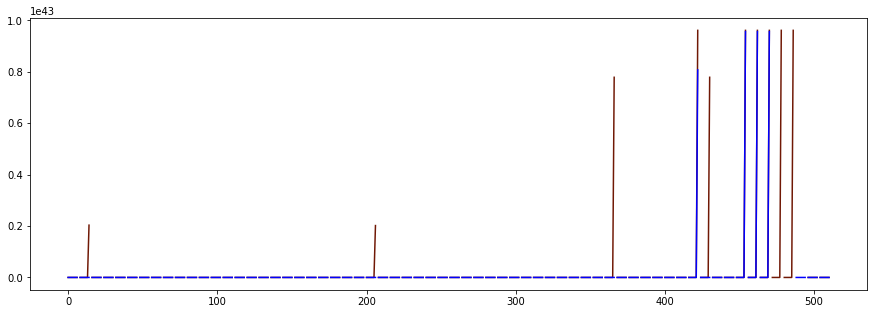

In [184]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(range(df.shape[0]), df['test_mape'], color = '#701805', label = "infections_r0_{}")
ax.plot(range(df.shape[0]), df['train_mape'], color = '#0000FF', label = "infections_r0_{}")


In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(range(df.shape[0]), df['test_mape'], color = '#701805', label = "infections_r0_{}")
ax.plot(range(df.shape[0]), df['train_mape'], color = '#0000FF', label = "infections_r0_{}")


In [174]:
sorted_df1

,alpha,beta,p,test_mape,test_rmsle,train_mape,train_rmsle
262,0.000000e+00,4.314585e+01,691.200000,72.699549,0.706008,133.189806,0.891085
286,2.375267e-109,0.000000e+00,691.200007,72.699550,0.706008,133.189807,0.891085
270,0.000000e+00,0.000000e+00,691.200011,72.699550,0.706008,133.189808,0.891085
278,2.035488e-65,2.888075e-06,691.200013,72.699550,0.706008,133.189808,0.891085
134,1.517520e-08,5.859124e-03,691.199988,72.699554,0.706008,133.189803,0.891085
158,2.889693e-08,0.000000e+00,691.199961,72.699558,0.706008,133.189797,0.891085
289,9.959226e-23,0.000000e+00,691.201464,72.699650,0.706008,133.190088,0.891085
94,7.079330e-04,0.000000e+00,689.695128,72.879500,0.703498,132.860322,0.889448
265,3.049762e+72,0.000000e+00,370.368304,76.118059,0.702714,100.667793,0.770481
346,2.202647e+04,0.000000e+00,371.240752,76.238474,0.702720,100.952041,0.771335


In [175]:
sorted_df2

,alpha,beta,p,test_mape,test_rmsle,train_mape,train_rmsle
10,1.754297e-01,5.926414,890.647620,188.739289,1.047336,7.197756,0.117561
73,1.753828e-01,5.929284,891.078924,188.827825,1.047573,7.199134,0.117529
146,1.753891e-01,5.928348,890.932900,188.794160,1.047483,7.200227,0.117583
17,1.753693e-01,5.929751,891.141774,188.837870,1.047600,7.200317,0.117550
66,1.753666e-01,5.928958,891.031249,188.810883,1.047527,7.202781,0.117642
138,1.753674e-01,5.928806,891.013949,188.807410,1.047518,7.203049,0.117654
2,1.753641e-01,5.928960,891.024663,188.807882,1.047519,7.203153,0.117652
34,1.753493e-01,5.929814,891.161376,188.836625,1.047596,7.203788,0.117650
81,1.753378e-01,5.930772,891.348784,188.881643,1.047717,7.203864,0.117632
77,1.753427e-01,5.930173,891.212894,188.846648,1.047622,7.204065,0.117648


In [172]:
df = pd.DataFrame(all_metrics)
print(df)

        alpha          beta             p     test_mape  test_rmsle  \
0    1.001001  9.999996e-04  1.001001e+00  9.964202e+01    5.269716   
1    0.175295  5.930980e+00  8.913623e+02  1.888688e+02    1.047680   
2    0.175364  5.928960e+00  8.910247e+02  1.888079e+02    1.047519   
3    1.001001  1.000000e-03  1.000000e+00  9.964238e+01    5.270211   
4    0.175344  5.929816e+00  8.911587e+02  1.888340e+02    1.047589   
5    1.000652  1.796149e-03  3.768357e+02  7.701069e+01    0.702948   
6    8.317415  3.703885e-10  3.712432e+02  7.623882e+01    0.702720   
7    1.001001  1.000000e-03           inf           inf         inf   
8    1.001001  9.999962e-03  1.001001e+00  9.964202e+01    5.269716   
9    0.175289  5.931505e+00  8.914020e+02  1.888733e+02    1.047692   
10   0.175430  5.926414e+00  8.906476e+02  1.887393e+02    1.047336   
11   1.001001  1.000000e-02  1.000000e+00  9.964238e+01    5.270211   
12   0.175344  5.929828e+00  8.911602e+02  1.888343e+02    1.047589   
13   0

In [148]:
curve_model = CurveModel(
    train_df,
    col_t,
    col_obs,
    col_covs,
    col_group,
    param_names,
    link_fun,
    var_link_fun,
    fun
)

IndexError: tuple index out of range

In [133]:
# Initialize params
fe_init   = np.ones(num_fe)
re_init   = np.ones(num_fe)
fe_bounds = [[-np.inf, np.inf], [0, np.inf], [0, np.inf]] 
print(fe_bounds)
re_bounds = [[0.0, 0.0]] * num_fe

[[-inf, inf], [0, inf], [0, inf]]


In [134]:
curve_model.fit_params(fe_init, re_init, fe_bounds, re_bounds)
params_estimate = curve_model.params
fe_estimate     = curve_model.result.x[: num_fe]

In [135]:
params_estimate

array([[1.75344654e-01],
       [5.92980445e+00],
       [8.91156419e+02]])

In [136]:
curve_model.compute_rmse()

10.403866626400394

In [137]:
out = curve_model.predict(
    t=np.array(np.arange(10, 18)),
    group_name=region
)

In [138]:
out

array([751.76709519, 798.18562384, 832.2249516 , 855.70510498,
       870.94040202, 880.23928122, 885.57803095, 888.46124801])

In [139]:
test_active_cases['cumulative_count']

0     92
1    184
2    284
3    388
4    496
5    610
6    726
7    852
Name: cumulative_count, dtype: object

In [140]:
compute_mape(test_active_cases['cumulative_count'], out)

188.83355849894704

In [141]:
rmsle_error(test_active_cases['cumulative_count'], out)

1.0475871965388892

In [142]:
rmse_error(test_active_cases['cumulative_count'], out)

443.3141391757227

In [143]:
out_train = curve_model.predict(
    t=np.array(np.arange(0, 10)),
    group_name=region
)

In [144]:
out_train

array([ 63.02351047,  98.70938465, 146.95708467, 208.31739285,
       281.72300957, 364.32719339, 451.76633575, 538.8307884 ,
       620.37760187, 692.22386719])

In [145]:
train_active_cases['cumulative_count']

0     44
1     90
2    152
3    218
4    292
5    370
6    448
7    526
8    612
9    704
Name: cumulative_count, dtype: object

In [129]:
compute_mape(train_active_cases['cumulative_count'], out_train)

7.204597238640497

In [130]:
rmsle_error(train_active_cases['cumulative_count'], out_train)

0.11767288381890502

In [131]:
rmse_error(train_active_cases['cumulative_count'], out_train)

10.403866626400394